In [1]:
import tensorflow as tf
import pandas as pd                                         # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np                                          # linear algebra
from tensorflow.keras.models import Sequential              # model type
from tensorflow.keras.layers import Dense, Dropout          # dense layer, dropout layer
from tensorflow.keras.activations import relu, sigmoid      # activation functions
from tensorflow.keras.optimizers import SGD                 # stochastic gradient descent
from tensorflow.keras.losses import binary_crossentropy     # cost function

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Fraud_Detection_Dataset.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
999994,45,PAYMENT,2987.49,C2072426611,579096.28,576108.80,M58668896,0.0,0.0,0,0
999995,45,PAYMENT,10913.42,C1384914558,576108.80,565195.38,M166797080,0.0,0.0,0,0
999996,45,PAYMENT,2014.46,C1207593845,565195.38,563180.92,M1027899613,0.0,0.0,0,0
999997,45,PAYMENT,18839.45,C260638437,563180.92,544341.47,M243388883,0.0,0.0,0,0


In [15]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            999999 non-null  int64  
 1   type            999999 non-null  object 
 2   amount          999999 non-null  float64
 3   nameOrig        999999 non-null  object 
 4   oldbalanceOrg   999999 non-null  float64
 5   newbalanceOrig  999999 non-null  float64
 6   nameDest        999999 non-null  object 
 7   oldbalanceDest  999999 non-null  float64
 8   newbalanceDest  999999 non-null  float64
 9   isFraud         999999 non-null  int64  
 10  isFlaggedFraud  999999 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 83.9+ MB


In [17]:
cat_columns = df.select_dtypes(include='object').columns
df[cat_columns]

,type,nameOrig,nameDest
0,PAYMENT,C1231006815,M1979787155
1,PAYMENT,C1666544295,M2044282225
2,TRANSFER,C1305486145,C553264065
3,CASH_OUT,C840083671,C38997010
4,PAYMENT,C2048537720,M1230701703
...,...,...,...
999994,PAYMENT,C2072426611,M58668896
999995,PAYMENT,C1384914558,M166797080
999996,PAYMENT,C1207593845,M1027899613
999997,PAYMENT,C260638437,M243388883


In [18]:
num_columns = df.select_dtypes(include=np.number).columns
df[num_columns]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.00,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.00,19384.72,0.0,0.0,0,0
2,1,181.00,181.00,0.00,0.0,0.0,1,0
3,1,181.00,181.00,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.00,29885.86,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...
999994,45,2987.49,579096.28,576108.80,0.0,0.0,0,0
999995,45,10913.42,576108.80,565195.38,0.0,0.0,0,0
999996,45,2014.46,565195.38,563180.92,0.0,0.0,0,0
999997,45,18839.45,563180.92,544341.47,0.0,0.0,0,0


In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [20]:
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']
smote = SMOTE()

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['type']),
        ('num', StandardScaler(), num_columns[:-2])
    ])

p = Pipeline(steps=[('preprocessor', preprocessor)])

In [22]:
Xp = p.fit_transform(X)
Xp.shape

(999999, 10)

In [23]:
Xp, y = smote.fit_resample(Xp, y)
Xp.shape, y.shape

((1998928, 10), (1998928,))

#### Create a Neural Network

In [24]:
model = Sequential()
model.add(Dense(units=256, activation=relu, input_shape=(Xp.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=128, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation=sigmoid))


In [25]:
# optimizer is stochastic gradient descent, which is a good default optimizer, for more info see https://keras.io/api/optimizers/sgd/
model.compile(
    optimizer=SGD(),
    loss=binary_crossentropy,
    metrics=['accuracy', 'Precision', 'Recall']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [26]:
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1599142, 10), (399786, 10), (1599142,), (399786,))

In [27]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Epoch 1/10
39979/39979 [==============================] - 136s 3ms/step - loss: 0.2062 - accuracy: 0.9077 - precision: 0.9008 - recall: 0.9163 - val_loss: 0.1193 - val_accuracy: 0.9486 - val_precision: 0.9382 - val_recall: 0.9606
Epoch 2/10
39979/39979 [==============================] - 135s 3ms/step - loss: 0.1385 - accuracy: 0.9398 - precision: 0.9262 - recall: 0.9558 - val_loss: 0.1168 - val_accuracy: 0.9543 - val_precision: 0.9670 - val_recall: 0.9408
Epoch 3/10
39979/39979 [==============================] - 127s 3ms/step - loss: 0.1228 - accuracy: 0.9468 - precision: 0.9325 - recall: 0.9633 - val_loss: 0.0944 - val_accuracy: 0.9601 - val_precision: 0.9419 - val_recall: 0.9808
Epoch 4/10
39979/39979 [==============================] - 134s 3ms/step - loss: 0.1126 - accuracy: 0.9517 - precision: 0.9368 - recall: 0.9687 - val_loss: 0.0973 - val_accuracy: 0.9516 - val_precision: 0.9182 - val_recall: 0.9917
Epoch 5/10
39979/39979 [==============================] - 135s 3ms/step - loss: 

In [28]:
model.evaluate(X_test, y_test)

12494/12494 [==============================] - 20s 2ms/step - loss: 0.0585 - accuracy: 0.9773 - precision: 0.9626 - recall: 0.9933


[0.05854636803269386,
 0.9773103594779968,
 0.9625626802444458,
 0.9932863712310791]

12494/12494 [==============================] - 17s 1ms/step


<Axes: >

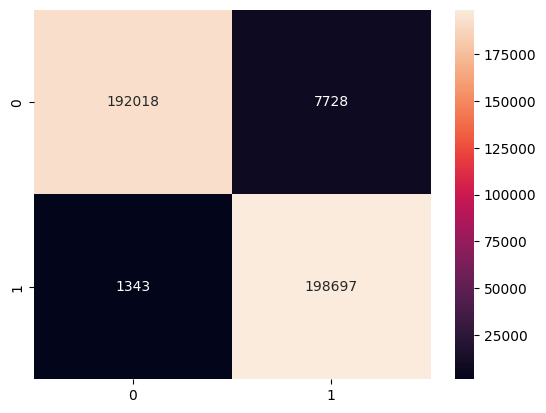

In [29]:
import seaborn as sns
# heatmap
ypred = model.predict(X_test)
ypred = ypred > 0.5
cm = confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')

In [30]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    199746
           1       0.96      0.99      0.98    200040

    accuracy                           0.98    399786
   macro avg       0.98      0.98      0.98    399786
weighted avg       0.98      0.98      0.98    399786



#### Save the model

In [31]:
from joblib import dump
model.save('ann_model_6_layer.h5')
dump(p, 'ann_model_6_layer_preprocessor.jb')

['ann_model_6_layer_preprocessor.jb']

#### Load the model and preprocessor

In [32]:
from joblib import load
def load_model():
    model = tf.keras.models.load_model('ann_model_6_layer.h5')
    return model

def load_preprocessor():
    p = load('ann_model_6_layer_preprocessor.jb')
    return p

In [33]:
existing_model = load_model()
p = load_preprocessor()
existing_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [34]:
def predict_fraud(model, data):
    data = p.transform(data)
    prediction = model.predict(data)
    return prediction

In [35]:
data = pd.DataFrame({
    'step': [1],
    'type': ['CASH_OUT'],
    'amount': [1000],
    'name_orig': ['C12345'],
    'oldbalanceOrg': [1000],
    'newbalanceOrig': [0],
    'name_dest': ['M12345'],
    'oldbalanceDest': [0],
    'newbalanceDest': [0],
})

out = predict_fraud(existing_model, data)
print(out[0][0] > 0.5)

1/1 [==============================] - 0s 98ms/step
True


In [ ]:
n = None
print(n)
print(not n)

None
True
